In [11]:
##basic chatbot using groq and LLama##
from typing import TypedDict,Annotated,List
from langgraph.graph import add_messages,StateGraph,END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage,HumanMessage
from dotenv import load_dotenv
from PIL import Image
import io
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
##Memory save is best for in chat saver (shutting down the server would break the persistence ###

from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
load_dotenv()


True

In [2]:
memory = MemorySaver()
llm_model = ChatGroq(model = 'llama-3.1-8b-instant')
search_tools = TavilySearchResults(max_results=2)
tools = [search_tools]

llm_with_tool = llm_model.bind_tools(tools = tools)

class BasicChatState(TypedDict):
    messages: Annotated[List[str],add_messages]

def chatNode(state:BasicChatState):
    return {
        "messages": [llm_with_tool.invoke(state["messages"])] 
    }

In [3]:
def tools_router(state:BasicChatState):

    last_message = state["messages"][-1] ##getting the last message in the list
    ##check if the last message has attribute tool calls##
    if (hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0):
        return "toolNode"
    else:
        return END

In [4]:
## building the tool node ###
from langgraph.prebuilt import ToolNode
toolNode = ToolNode(tools=tools,messages_key="messages") 
## this node checks for the last ai message and excutes the tool ##
##specified the messages key in state
##default is "messages"

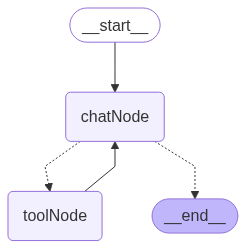

In [8]:
graph = StateGraph(BasicChatState)
graph.add_node("chatNode",chatNode)
graph.add_node("toolNode",toolNode)
graph.add_conditional_edges("chatNode",tools_router)
graph.set_entry_point("chatNode")
graph.add_edge("toolNode","chatNode")
app = graph.compile(checkpointer=memory) ### using the checkpointer in the graph itself
png = app.get_graph().draw_mermaid_png()
display(Image(png))

In [9]:
### config using the thread id ###
config = {"configurable":{

    "thread_id":1
}}

while True:
    user_input = input('User: ')
    if user_input.lower() in ['end','exit']:
        break
    else:
        result = app.invoke({
            "messages": [HumanMessage(content=user_input)]
        }, config=config)

        print("AI: " + result["messages"][-1].content)

User:  Hi My name is shivargha


AI: Hello Shivargha. I'm happy to help you with any questions or tasks you may have. What's on your mind today?


User:  What is my name?


AI: It seems that there is an ancient inscription associated with the name "Shivargha", and it refers to a temple compound dedicated to Shiva. However, it's not clear if this is directly related to your personal name.


User:  end


## SQLITE Memory

In [23]:
## Running the SQL ##
sqlite_conn = sqlite3.connect("checkpoint.sqlite",check_same_thread=False)
## sqlite internally wants only one thread and save the persistence of only 1 thread ##
memory = SqliteSaver(sqlite_conn)

In [14]:
llm_model = ChatGroq(model = 'llama-3.1-8b-instant')
search_tools = TavilySearchResults(max_results=2)
tools = [search_tools]

llm_with_tool = llm_model.bind_tools(tools = tools)

class BasicChatState(TypedDict):
    messages: Annotated[List[str],add_messages]

def chatNode(state:BasicChatState):
    return {
        "messages": [llm_with_tool.invoke(state["messages"])] 
    }

In [15]:
def tools_router(state:BasicChatState):

    last_message = state["messages"][-1] ##getting the last message in the list
    ##check if the last message has attribute tool calls##
    if (hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0):
        return "toolNode"
    else:
        return END

In [16]:
## building the tool node ###
from langgraph.prebuilt import ToolNode
toolNode = ToolNode(tools=tools,messages_key="messages") 
## this node checks for the last ai message and excutes the tool ##
##specified the messages key in state
##default is "messages"

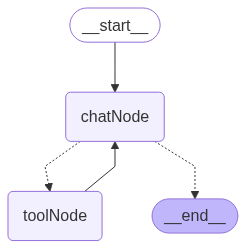

In [24]:
graph = StateGraph(BasicChatState)
graph.add_node("chatNode",chatNode)
graph.add_node("toolNode",toolNode)
graph.add_conditional_edges("chatNode",tools_router)
graph.set_entry_point("chatNode")
graph.add_edge("toolNode","chatNode")
app = graph.compile(checkpointer=memory) ### using the checkpointer in the graph itself
png = app.get_graph().draw_mermaid_png()
display(Image(png))

In [25]:
### config using the thread id ###
config = {"configurable":{

    "thread_id":1
}}

while True:
    user_input = input('User: ')
    if user_input.lower() in ['end','exit']:
        break
    else:
        result = app.invoke({
            "messages": [HumanMessage(content=user_input)]
        }, config=config)

        print("AI: " + result["messages"][-1].content)

User:  Hi My name is Shivargha


AI: Nice to meet you, Shivargha. Is there something I can help you with today?


User:  What is my name?


AI: <function=tavily_search_results_json>{"query": "your name is Shivargha"}


User:  end


In [26]:
##Checking the persistence of the graph ###
config = {"configurable":{

    "thread_id":1
}}

while True:
    user_input = input('User: ')
    if user_input.lower() in ['end','exit']:
        break
    else:
        result = app.invoke({
            "messages": [HumanMessage(content=user_input)]
        }, config=config)

        print("AI: " + result["messages"][-1].content)

User:  What is my name?


AI: Your name is Shivargha.


User:  end
